# Introduction to Interpretable Machine Learning 


In this tutorial, we will look into the [Grad-CAM method](https://arxiv.org/abs/1610.02391), which provides visual explanations from deep networks via gradient-based Localization.

The data for this demo can be downlaoded from here: https://drive.google.com/file/d/1mHRcFslRhgsmvByBLPyg67quUm59DWyC/view?usp=sharing

Learning goal:
- Introduce the Grad-CAM technique for machine learning model interpretability. 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D,MaxPooling2D,Flatten, Dropout, Dense
from tensorflow.keras.activations import softmax, relu
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.cm as cm
from IPython.display import Image, display

In [2]:
# Loading data
samples = np.load("..\\Data\\CC-359-demo\\cc_samples.npy")
field_labels = np.load("..\\Data\\CC-359-demo\\magnetic_field_labels.npy").astype(int)
vendor_labels = np.load("..\\Data\\CC-359-demo\\scanner_vendor_labels.npy").astype(int) 
labels = 3*field_labels + vendor_labels # combined vendor + field label - labels go from 0 to 5

# Shuffling samples
indexes = np.arange(samples.shape[0],dtype = int)
np.random.shuffle(indexes)
samples = samples[indexes]
field_labels = field_labels[indexes]
vendor_labels = vendor_labels[indexes]
labels = labels[indexes]

# Labels mapping
field_dic = {"0":"1.5 T","1":"3 T"}
vendor_dic = {"0":"Philips","1":"GE","2":"Siemens"}

class_names = ["Philips 1.5 T","GE 1.5 T","Siemens 1.5 T", "Philips 3 T","GE 3 T","Siemens 3 T"]

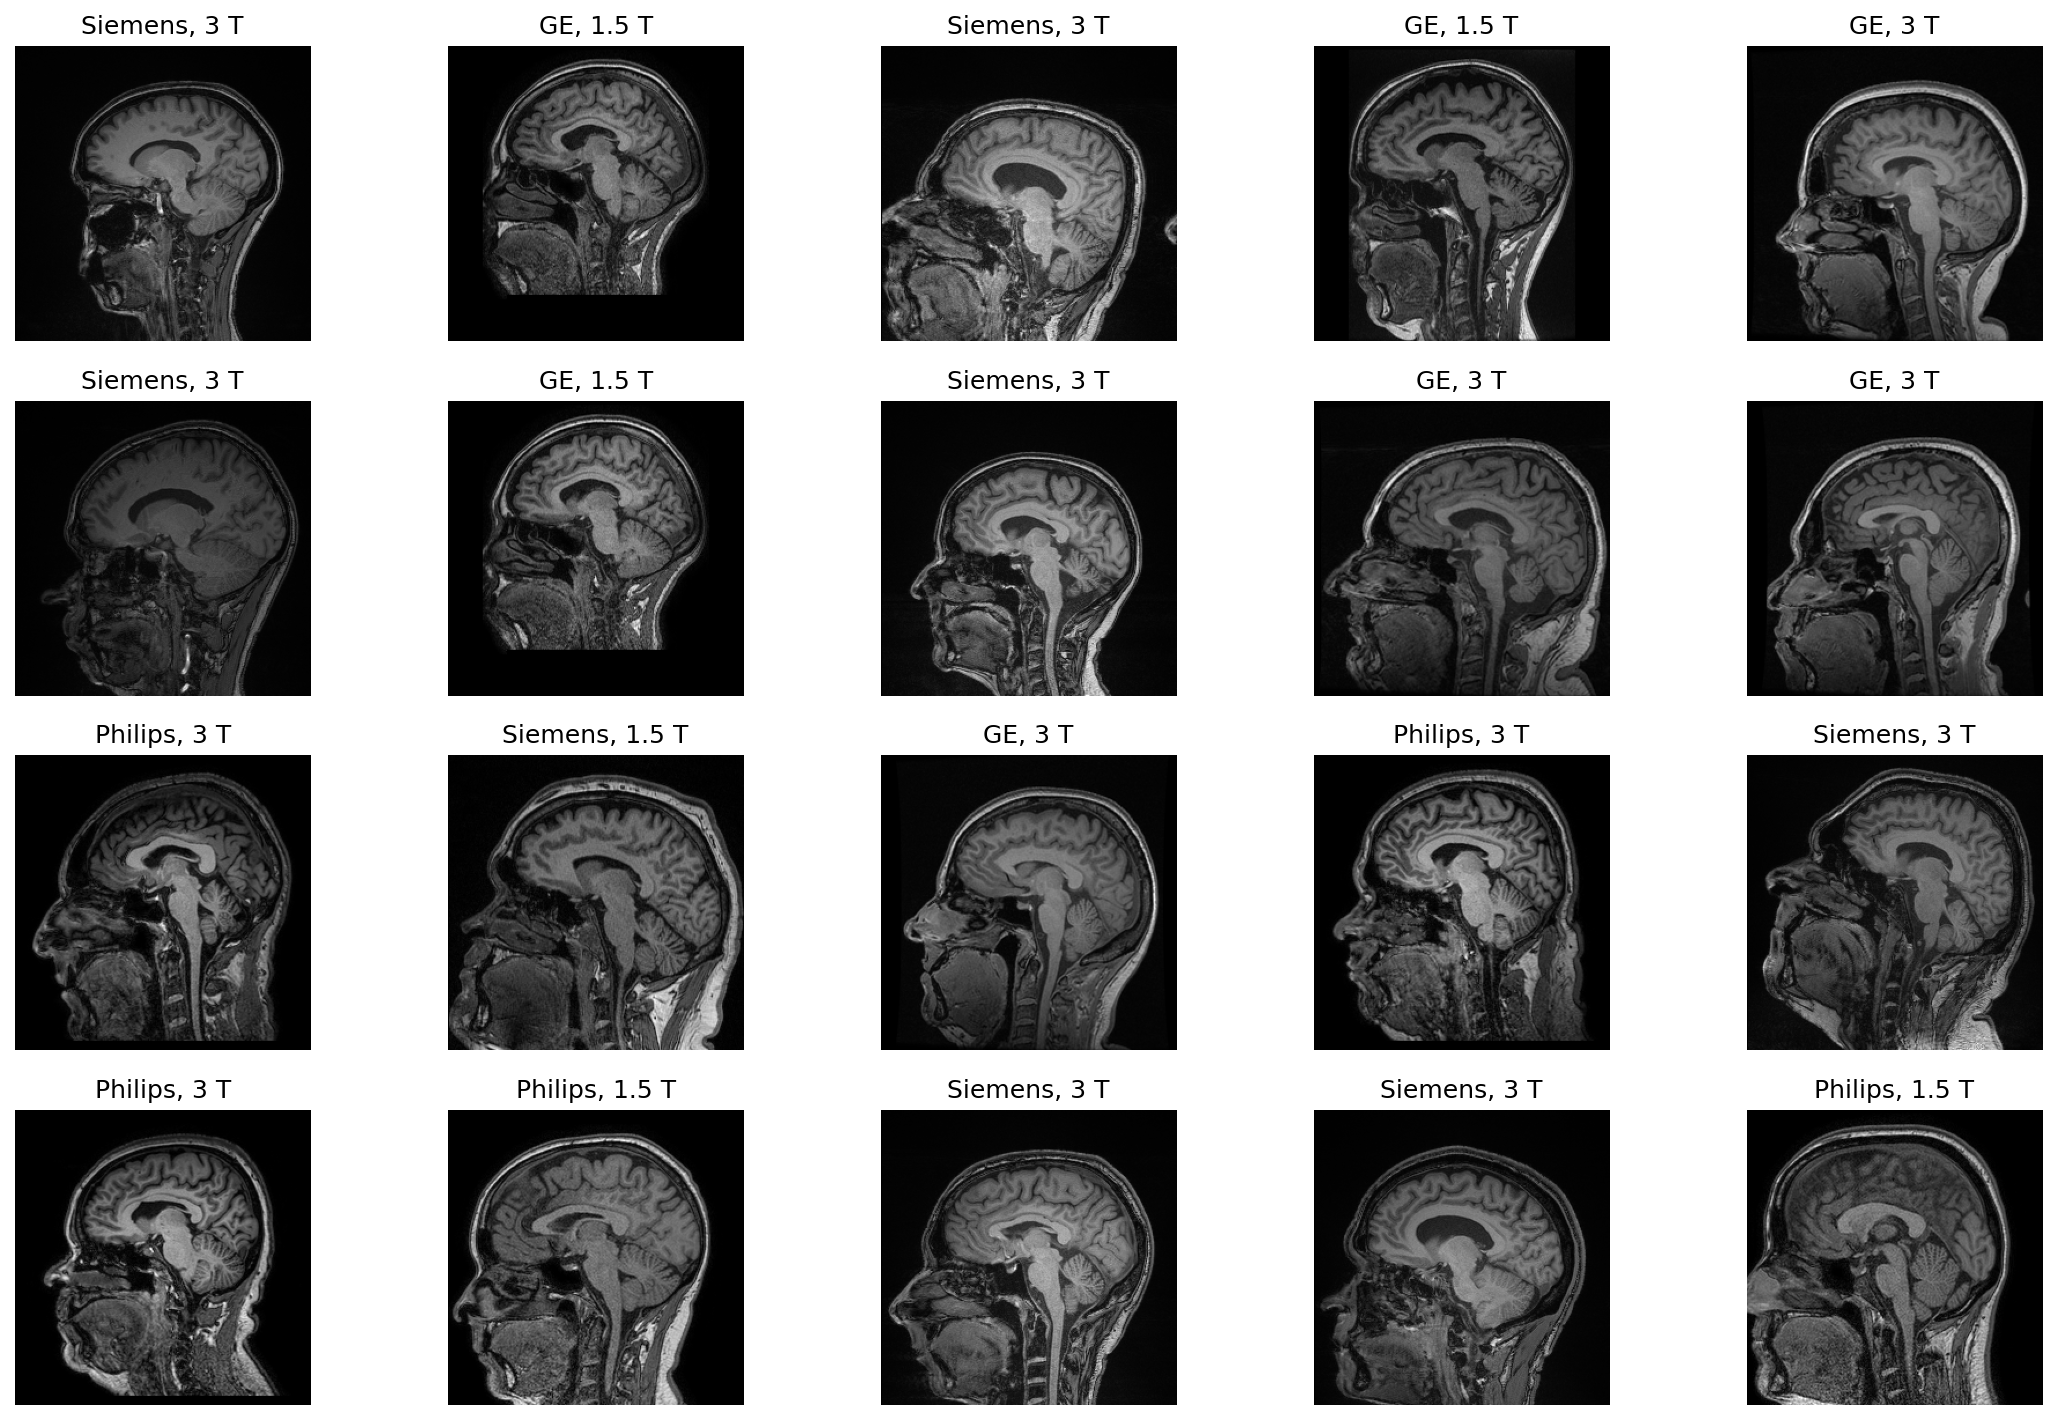

In [3]:
# Display some samples
skip = 180
plt.figure(dpi = 150, figsize = (18,12))
for ii in range(20):
    plt.subplot(4,5,ii+1)
    plt.imshow(samples[ii*skip],cmap = "gray")
    plt.axis("off")
    plt.title("%s, %s" %(vendor_dic[str(vendor_labels[ii*skip])],field_dic[str(field_labels[ii*skip])]))
plt.show()

In [4]:
# STratified splitting into train/test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss.get_n_splits(samples,labels)
train_index, test_index = next(sss.split(samples,labels))

samples_train = samples[train_index]
labels_train = labels[train_index] 
field_labels_train = field_labels[train_index]
vendor_labels_train = vendor_labels[train_index]



samples_test = samples[test_index]
labels_test = labels[test_index] 
field_labels_test = field_labels[test_index]
vendor_labels_test = vendor_labels[test_index]

# One-hot-encoding -is the format used as input when training the network
labels_train = tf.keras.utils.to_categorical(labels_train, 6)

In [5]:
# Our model
def my_model(input_shape):
    input_signal = Input(input_shape)
    
    # First block
    conv1 = Conv2D(32, kernel_size=(3, 3),
                 input_shape=input_shape, activation = 'relu')(input_signal)
    conv1 = Conv2D(32,kernel_size=(3,3), activation = 'relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    drop1 = Dropout(0.25)(pool1)
    
    # Second block
    conv2 = Conv2D(48, kernel_size=(3, 3), activation = 'relu')(drop1)
    conv2 = Conv2D(48,kernel_size=(3,3), activation = 'relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    drop2 = Dropout(0.25)(pool2)
    # Third block
    conv3 = Conv2D(64, kernel_size=(3, 3), activation = 'relu')(drop2)
    conv3 = Conv2D(64,kernel_size=(3,3), activation = 'relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    drop3 = Dropout(0.25)(pool3)
    
    flat = Flatten()(drop3)
    pred = Dense(6, activation = 'softmax')(flat)
    model = Model(inputs=input_signal, outputs=pred)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
    return model

In [6]:
#Building the model and showing a summary
model = my_model((256,256,1))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 48)      13872     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 48)      20784 

In [7]:
model_name = '..\\Data\\vendor_field_cnn.h5'
# Checkpoint callback to save model after each improvement along the epochs
checkpoint = ModelCheckpoint(model_name, monitor='val_loss'
                             ,verbose=0,save_weights_only= True,
                             save_best_only=True)

In [8]:
history = model.fit(samples_train[:,:,:,np.newaxis], labels_train,\
                    batch_size=16,
                    epochs=5,
                    verbose=1,
                    validation_split= 0.2,callbacks = [checkpoint],shuffle = True)

Epoch 1/5
135/135 [==============================] - 114s 504ms/step - loss: 0.9356 - accuracy: 0.5912 - val_loss: 0.1712 - val_accuracy: 0.9406
Epoch 2/5
135/135 [==============================] - 5s 36ms/step - loss: 0.1468 - accuracy: 0.9576 - val_loss: 0.0568 - val_accuracy: 0.9852
Epoch 3/5
135/135 [==============================] - 5s 35ms/step - loss: 0.0451 - accuracy: 0.9886 - val_loss: 0.0118 - val_accuracy: 0.9963
Epoch 4/5
135/135 [==============================] - 5s 35ms/step - loss: 0.0075 - accuracy: 0.9968 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 5/5
135/135 [==============================] - 5s 35ms/step - loss: 8.4037e-04 - accuracy: 1.0000 - val_loss: 1.2503e-04 - val_accuracy: 1.0000


In [9]:
# Testing the model
model.load_weights(model_name)
pred = np.argmax(model.predict(samples_test[:,:,:,np.newaxis]),axis = 1) # Label is the one with maximum probability
print("Test set accuracy:", (pred == labels_test).sum()/pred.size)

Test set accuracy: 1.0


In [10]:
# Display some samples
mistakes = np.where(pred != labels_test)[0]
print(mistakes)
cols = 3
rows = np.ceil(mistakes.size/cols)

plt.figure(dpi = 150, figsize = (18,12))
counter = 1
for ii in mistakes:
    plt.subplot(rows,cols,counter)
    plt.imshow(samples_test[ii],cmap = "gray")
    plt.axis("off")
    plt.title("Predicted= %s, %s.\n Ground truth: %s, %s" %(vendor_dic[str(vendor_labels_test[ii])],\
                                                          field_dic[str(field_labels_test[ii])],\
                                                          vendor_dic[str(pred[ii]%3)],\
                                                          field_dic[str(pred[ii]//3)]))
    counter+=1
plt.show()

[]


<Figure size 2700x1800 with 0 Axes>

In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print(tf.shape(pooled_grads.shape))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    
    if img.ndim == 2:
        img = np.array([img,img,img]).transpose(1,2,0)
        
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [12]:
last_conv_layer_name = "conv2d_5"
model.layers[-1].activation = None
print(model.layers[-1].activation)

None


0.0 202.7226345083488
tf.Tensor([1], shape=(1,), dtype=int32)


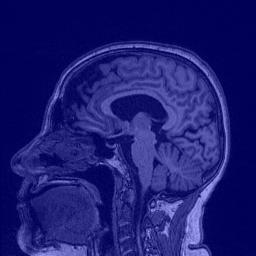

In [13]:
idx = 100
x = samples_test[idx,:,:,np.newaxis]*255
print(x.min(),x.max())
pred_index = labels_test[idx]

# Generate wrong class activation heatmap
heatmap = make_gradcam_heatmap(x[np.newaxis], model, last_conv_layer_name)
save_and_display_gradcam(x[:,:,0], heatmap,alpha=0.4)

In [14]:
# # Generate correct class activation heatmap
# heatmap = make_gradcam_heatmap(x[np.newaxis], model, last_conv_layer_name, pred_index)
# save_and_display_gradcam(x[:,:,0], heatmap)